# Libraries

In [1]:
import sys

sys.path.append("/home/lucas/Image-Denoising")

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from src.model import VisionModel
from src.noises import add_noise
from src.dataset import CustomImageDataset

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import MNIST

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Transform function

In [2]:
class AddNoise(torch.nn.Module):
    def forward(self, img):
        img = np.array(img)
        noisy_image = add_noise(img, noise_type='exponential', scale=100,sigma=150)
        noisy_image = add_noise(noisy_image, noise_type='gaussian', scale=100,sigma=150)

        return Image.fromarray(noisy_image)

In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),       # Resize the image to 256x256 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize the image
])

In [2]:
class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

In [25]:
noise = AddNoise()
transform = v2.Compose([
    #v2.Resize((28, 28)),       # Resize the image to 256x256 pixels
    #v2.ToTensor(),            # Convert the image to a PyTorch tensor
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True)
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    #v2.Normalize(mean=[0.485], std=[0.229])  # Normalize the image
])

# 2. Load Train and Test Dataset

## 2.1 MNIST Dataset

In [4]:
class MNISTCustomDataset(MNIST):
    def __init__(self,root_dir,train,transform_function,noise_function):
        super().__init__(root_dir,download=True,train=train)
        self.transform_function = transform_function
        self.noise_function = noise_function
    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        original_img = Image.fromarray(img.numpy(), mode="L")
        noise_img = original_img.copy()

        original_img = self.transform_function(original_img)
        
        noise_img = self.noise_function(noise_img)
        noise_img = self.transform_function(noise_img)

        return original_img, noise_img

In [5]:
mnist_dataset_train = MNISTCustomDataset("./",True,transform,AddNoise())
mnist_dataset_test = MNISTCustomDataset("./",False,transform,AddNoise())

In [6]:
total = mnist_dataset_train.__len__() + mnist_dataset_test.__len__()

print(f"Train: {round(mnist_dataset_train.__len__()/total,2)}\nTest: {round(mnist_dataset_test.__len__()/total,2)}")

Train: 0.86
Test: 0.14


## 2.2 MNIST Dataloader

In [41]:
batch_size = 256
num_workers = 8

mnist_dataloader_train = DataLoader(
    mnist_dataset_train,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)

mnist_dataloader_test = DataLoader(
    mnist_dataset_test,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

## 2.3 Custom Dataset

In [21]:
path = "/home/lucas/datasets/dataframe_v1.csv"
df = pd.read_csv(path)

In [22]:
train = df[df["split"] == 'train']
test = df[df["split"] == 'test']
val = df[df["split"] == 'val']

In [26]:
train_dataset = CustomImageDataset(train,transform,noise)
test_dataset = CustomImageDataset(test,transform,noise)
val_dataset = CustomImageDataset(val,transform,noise)

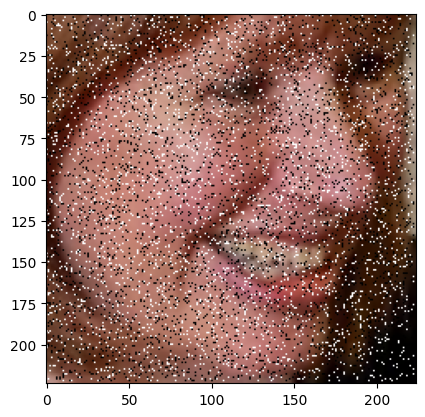

In [27]:
plt.imshow(val_dataset.__getitem__(10)[1].permute(1, 2, 0))

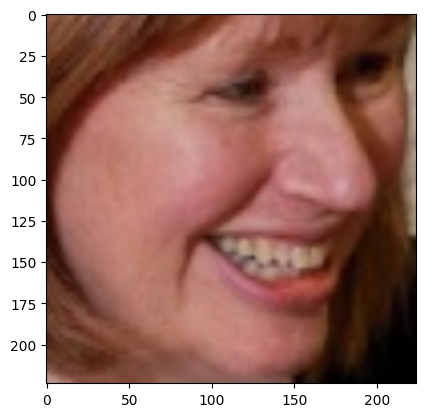

In [28]:
plt.imshow(val_dataset.__getitem__(10)[0].permute(1, 2, 0))

## 2.4 Custom Dataloader

In [29]:
batch_size = 4
num_workers = 8

custom_dataloader_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)

custom_dataloader_val = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

custom_dataloader_test = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

# 3. Vision Transform Model

## 3.1 Model

In [53]:
for i in range(1,512):
    if(512%i == 0):
        print(i)

1
2
4
8
16
32
64
128
256


In [30]:
model = VisionModel(
    img_size=(batch_size,3,224,224),
    patch_size=14,
    token_len=512,
    num_layers=12,
    num_heads=16
)

model = model.cuda()

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## 3.2 Loss Function

In [31]:
loss_fn = nn.MSELoss()

## 3.3 Optimizer

In [32]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

# 3. Train model

In [33]:
epochs = 64

model = model.train()

for epoch in tqdm(range(1,epochs+1)):
    total_loss = 0
    count_idx = 0
    for ori_img, noi_img in (pbar := tqdm(custom_dataloader_train)):
        noi_img = noi_img.cuda()
        denoised_img = model(noi_img)
        denoised_img = denoised_img.cpu()
        
        loss = loss_fn(denoised_img, ori_img)

        optimizer.zero_grad()    
        loss.backward()
        optimizer.step()
        count_idx += 1
        total_loss += loss.item()
        pbar.set_description(f"Loss: {total_loss/count_idx}")

    test_total_loss = 0
    test_count_idx = 0
    with torch.no_grad():
        for ori_img, noi_img in tqdm(custom_dataloader_val):
            noi_img = noi_img.cuda()
            denoised_img = model(noi_img)
            denoised_img = denoised_img.cpu()
            
            loss = loss_fn(denoised_img, ori_img)
            test_count_idx += 1
            test_total_loss += loss.item()
        print(f"Test loss: {test_total_loss/test_count_idx}\n")

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

Test loss: 0.05740752033199425



  0%|          | 0/753 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
(14**2)*3

588

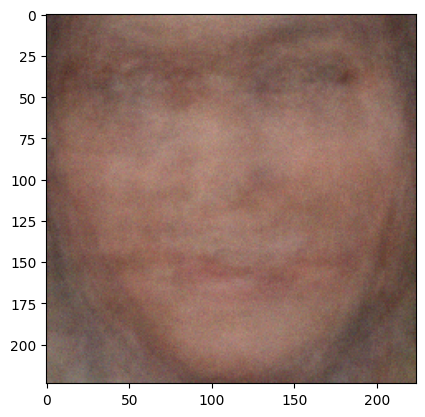

In [38]:
plt.imshow(denoised_img[1].permute(1, 2, 0).detach().numpy())

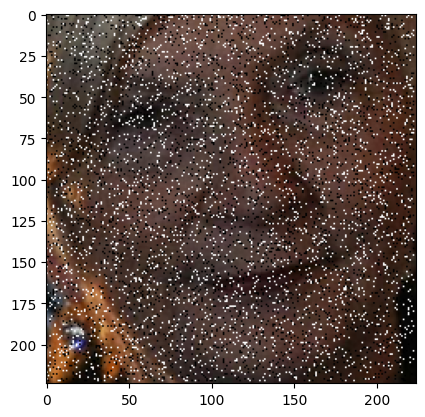

In [39]:
plt.imshow(noi_img[1].permute(1, 2, 0).detach().numpy())

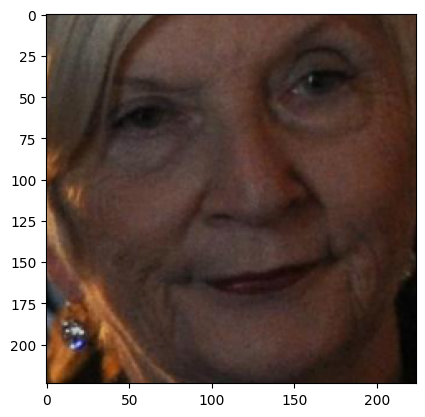

In [37]:
plt.imshow(ori_img[1].permute(1, 2, 0).detach().numpy())

In [58]:
with torch.no_grad():
    for ori_img, noi_img in tqdm(mnist_dataloader_test):
        break

  0%|          | 0/40 [00:00<?, ?it/s]

In [59]:
noi_img = noi_img.cuda()
denoised_img = model(noi_img)
denoised_img = denoised_img.cpu()

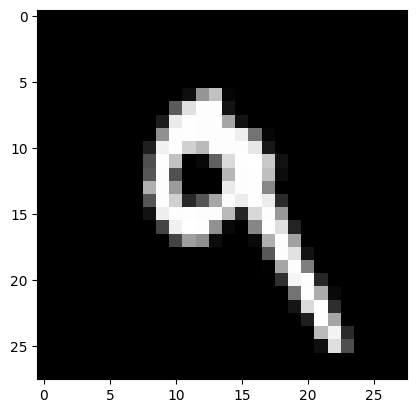

In [63]:
plt.imshow(ori_img[7].permute(1, 2, 0).detach().numpy(),cmap='gray')

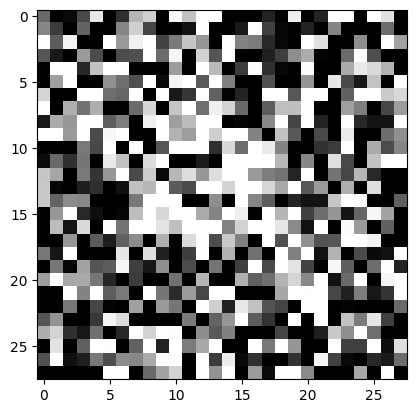

In [64]:
plt.imshow(noi_img[7].cpu().permute(1, 2, 0).detach().numpy(),cmap='gray')

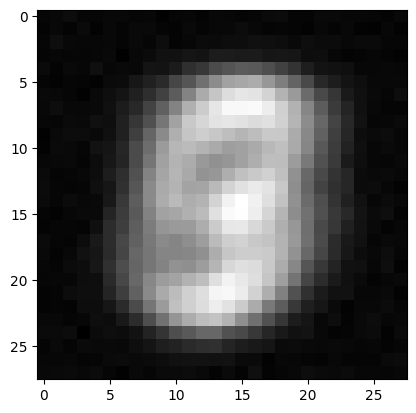

In [65]:
plt.imshow(denoised_img[7].permute(1, 2, 0).detach().numpy(),cmap='gray')